# 2022-10-26 Finite Elements

## Last time

* Questions about projects
* Galerkin methods
  * Weak forms
  * $L^2$ Projection
  * Galerkin "optimality"  
  
## Today
* 

In [2]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end


function vander_legendre(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    Q[:, 2] = x
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
    end
    Q
end

vander_legendre (generic function with 2 methods)

# Prime to nodal basis

A **nodal basis** $\{ \phi_j(x) \}$ is one that satisfies
$ n_i(\phi_j) = \delta_{ij} . $

We write $\phi_j$ in the prime basis by solving with the generalized Vandermonde matrix $V_{ij} = \langle n_i, p_j \rangle$,
$$ \phi_j(x) = \sum_k p_k(x) (V^{-1})_{k,j} . $$

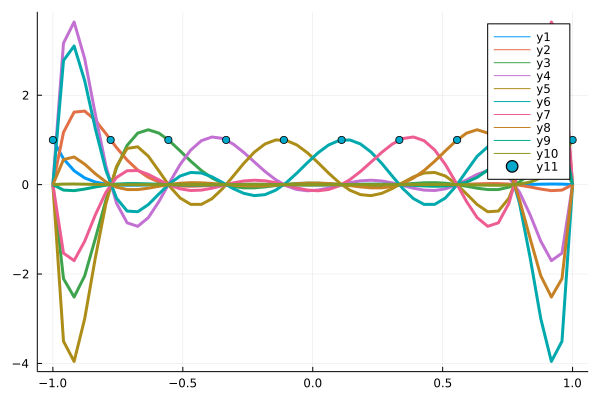

In [3]:
k = 10
xn = LinRange(-1, 1, k)
V = vander_legendre(xn)
xx = LinRange(-1, 1, 50)
Pxx = vander_legendre(xx, k)
Pn = Pxx / V
plot(xx, Pn)
scatter!(xn, one.(xn))

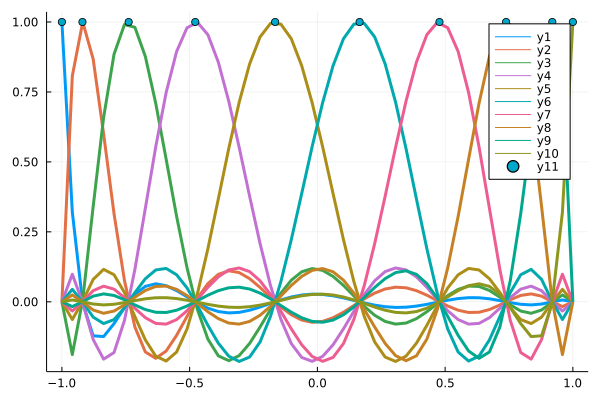

In [4]:
using FastGaussQuadrature
xn, _ = gausslobatto(k)
V = vander_legendre(xn)
Pn = Pxx / V
plot(xx, Pn)
scatter!(xn, one.(xn))

In [5]:
function vander_legendre_deriv(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    dQ = zeros(m, k)
    Q[:, 2] = x
    dQ[:, 2] .= 1
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
        dQ[:, n+2] = (2*n + 1) * Q[:,n+1] + dQ[:,n]
    end
    Q, dQ
end

vander_legendre_deriv (generic function with 2 methods)

# Galerkin method: $L^2$ projection

A nice test problem that doesn't require derivatives or boundary conditions:
Find $u \in \mathcal V_h$ such that
$$ \int_{-1}^1 v(x) \big[ u(x) - f(x) \big] = 0, \quad \forall v \in \mathcal V_h$$

In [6]:
function febasis(P, Q)
    x, _ = gausslobatto(P)
    q, w = gausslegendre(Q)
    Pk, _ = vander_legendre_deriv(x)
    Bp, Dp = vander_legendre_deriv(q, P)
    B = Bp / Pk
    D = Dp / Pk
    x, q, w, B, D
end

function L2_galerkin(P, Q, f)
    x, q, w, B, _ = febasis(P, Q)
    A = B' * diagm(w) * B
    rhs = B' * diagm(w) * f.(q)
    u = A \ rhs
    x, u
end

L2_galerkin (generic function with 1 method)

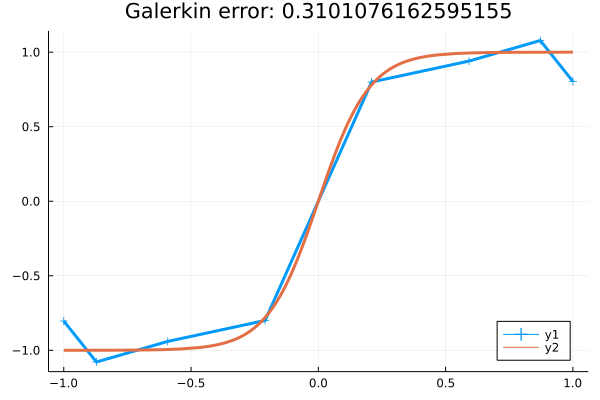

In [30]:
f(x) = tanh(5x)
P, Q = 8, 8
x, u = L2_galerkin(P, Q, f)
error = u - f.(x)
plot(x, u, marker=:auto, legend=:bottomright)
plot!(f, title="Galerkin error: $(norm(error))")

# Embed the solution in the continuous space

In thel last figure, the Galerkin solution was represented by a piecewise linear function, emphasizing its nodal values. Let's make a nicer plot by multiplying by the corresponding nodal basis function.

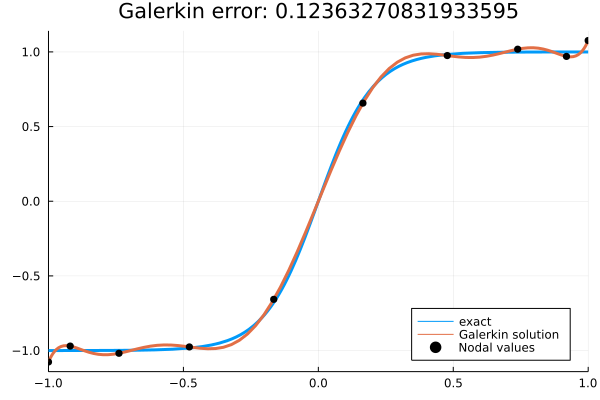

In [31]:
P, Q = 10, 12
x, u = L2_galerkin(P, Q, f)
error = u - f.(x)
_, xx, _, BB, _ = febasis(P, 100)
plot(f, label="exact", title="Galerkin error: $(norm(error))",
  xlim=(-1, 1), legend=:bottomright)
plot!(xx, BB * u, label="Galerkin solution")
scatter!(x, u, marker=:circle, color=:black, label="Nodal values")

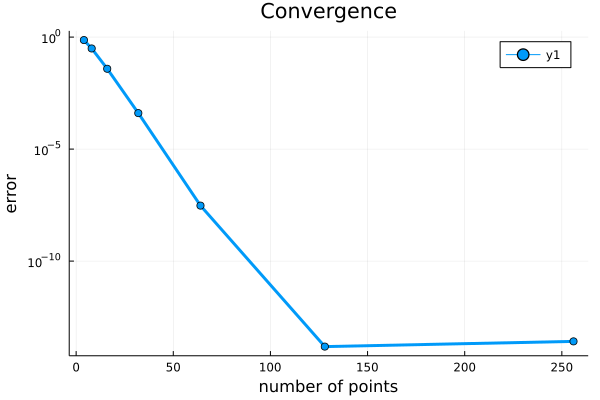

In [32]:
ns = 2 .^ (2:8)
function L2_error(n)
    x, u = L2_galerkin(n, n, f)
    norm(u - f.(x))
end
plot(ns, L2_error.(ns), marker=:circle, yscale=:log10,
  title="Convergence", xlabel="number of points", ylabel="error")

# Galerkin error estimates

We introduce the notation
$$ a(v, u) = \int_\Omega \nabla v(x) \cdot \nabla u(x) $$
and note that $a$ is
* bilinear (linear in each of its arguments)
* symmetric: $a(u, v) = a(v,u)$
* positive definite: $a(u, u) > 0$ when $u \ne 0$
thus defines an inner product on the function space $V$.

We also introduce the $L^2$ inner product
$$ \langle u, v \rangle = \int_\Omega u(x) v(x) $$
so that our continuous weak form is to find $u \in V$ such that
$$ a(v, u) = \langle v, f \rangle, \quad \forall v\in V. $$
Our Galerkin discretization is to find $u_h \in V_h \subset V$ such that
$$ a(v_h, u_h) = \langle v_h, f \rangle, \quad \forall v_h \in V_h . $$
Since $V_h \subset V$, we can subtract these two, yielding
$$ a(v_h, u_h - u) = 0, \quad \forall v_h \in V_h .$$
This says that the error in the discrete solution $u_h - u$ is $a$-orthogonal to all test functions $v_h$.

# Galerkin optimality via energy norms

We can also define the "energy norm" or $a$-norm,
$$ \lVert u \rVert_a = \sqrt{a(u,u)} . $$
This norm satisfies the Cauchy-Schwarz inequality,
$$ \lvert a(u,v) \rvert \le \lVert u \rVert_a \lVert v \rVert_a . $$
Now,
\begin{align}
\lVert u_h - u \rVert_a^2 &= a(u_h - u, u_h - u) \\
&= a(u_h - v_h, u_h - u) + a(v_h - u, u_h - u) \\
&= a(v_h - u, u_h - u) \\
&\le \lVert v_h - u \rVert_a \lVert u_h - u \rVert_a .
\end{align}
In other words,
$$\lVert u_h - u \rVert_a \le \lVert v_h - u \rVert_a, \quad \forall v_h \in V_h .$$
So the solution $u_h$ computed by the Galerkin discretization is optimal over the subspace $V_h$ as measured in the $a$-norm.

## Observations
* The Galerkin method computes the exact solution any time it resides in the subspace $V_h$.
* The Galerkin method is automatically symmetric any time the weak form is symmetric.
* The Galerkin method can be spectrally accurate, similar to the Chebyshev finite difference methods.
* For a nonlinear problem, discretization and differentiation will commute.

# Galerkin method for Poisson

$$ \int_{\Omega} \nabla v \cdot \kappa \cdot \nabla u = \int_{\Omega} v f, \forall v$$

In [14]:
function poisson_galerkin(P, Q, kappa, f)
    x, q, w, B, D = febasis(P, Q)
    A = D' * diagm(w .* kappa.(q)) * D
    rhs = B' * diagm(w) * f.(q)
    # Boundary conditions
    rhs[[1, end]] .= 0
    A[1, :] .= 0
    A[1, 1] = 1
    A[end, :] .= 0
    A[end, end] = 1
    u = A \ rhs
    x, u
end

poisson_galerkin (generic function with 1 method)

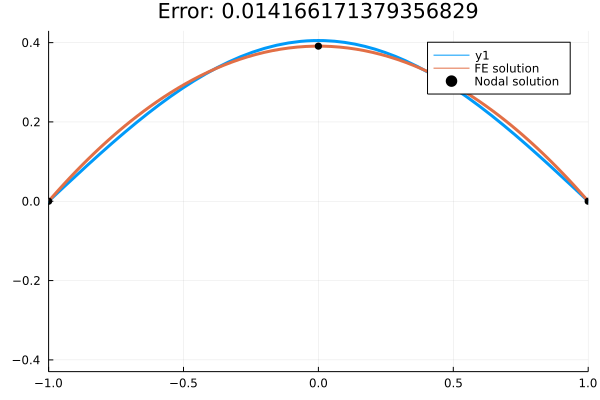

In [22]:
kappa(x) = 1# 0.6 .+ 0.4 * sin.(pi*x)
P = 3
x, u = poisson_galerkin(P, P, one, x -> cos(x*pi/2))
uexact(x) = cos(x*pi/2) * (2/pi)^2
plot(uexact, title="Error: $(norm(u - uexact.(x)))")
_, xx, _, BB, _ = febasis(P, 100)
plot!(xx, BB * u, label="FE solution", xlim=(-1, 1))
scatter!(x, u, label="Nodal solution", marker=:circle, color=:black)

## What if we only impose the boundary condition on one side?

# Galerkin preserves symmetry

The bilinear operator is symmetric if $a(v,u) = a(u,v)$,

$$ a(v,u) = \int_{\Omega} \nabla v \cdot \kappa \cdot \nabla u $$

This is symmetric even for
* variable coefficients
* any Neumann-type boundary conditions
* Dirichlet if eliminated or lifted symmetrically
* arbitrary grid spacing (and mesh topology in multiple dimensions)

In [23]:
x, q, w, B, D = febasis(7, 10)
A = D' * diagm(w .* kappa.(q)) * D
@show norm(A - A')
eigvals(A)

norm(A - A') = 1.8793004900806345e-15


7-element Vector{Float64}:
  5.707570676180179e-16
  0.4961610820037274
  2.509625052953609
  6.08350124916844
 11.035160143518413
 19.600337668827844
 21.875214803528042

## What if we use too few quadrature points?

![](../img/libCEED-2-trim.svg)

# General form
$$ \int_\Omega v\cdot f_0(u, \nabla u) + \nabla v\cdot f_1(u, \nabla u) = 0, \quad \forall v$$
we discretize as
$$ \sum_e \mathcal E_e^T \Big( B^T W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_0(\tilde u, \nabla \tilde u) + D^T \left(\frac{\partial X}{\partial x}\right)^{T} W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_1(\tilde u, \nabla\tilde u) \Big) = 0 $$
where $\tilde u = B \mathcal E_e u$ and $\nabla \tilde u = \frac{\partial X}{\partial x} D \mathcal E_e u$ are the values and gradients evaluated at quadrature points.

## Isoparametric mapping

Given the reference coordinates $X \in \hat K \subset R^n$ and physical coordinates $x(X)$, an integral on the physical element can be written
$$ \int_{K = x(\hat K)} f(x) dx = \int_K \underbrace{\left\lvert \frac{\partial x}{\partial X} \right\rvert}_{\text{determinant}} f(x(X)) dX .$$

| Notation | Meaning |
|---------|:-------------|
| $x$ | physical coordinates |
| $X$ | reference coordinates |
| $\mathcal E_e$ | restriction from global vector to element $e$ |
| $B$ | values of nodal basis functions at quadrature ponits on reference element |
| $D$ | gradients of nodal basis functions at quadrature points on reference element|
| $W$ | diagonal matrix of quadrature weights on reference element |
| $\frac{\partial x}{\partial X} = D \mathcal E_e x $ | gradient of physical coordinates with respect to reference coordinates |
| $\left\lvert \frac{\partial x}{\partial X}\right\rvert$ | determinant of coordinate transformation at each quadrature point |
| $\frac{\partial X}{\partial x} = \left(\frac{\partial x}{\partial X}\right)^{-1}$ | derivative of reference coordinates with respect to physical coordinates |

# Finite element mesh and restriction

In [33]:
function fe1_mesh(P, nelem)
    x = LinRange(-1, 1, nelem+1)
    rows = Int[]
    cols = Int[]
    for i in 1:nelem
        append!(rows, (i-1)*P+1:i*P)
        append!(cols, (i-1)*(P-1)+1:i*(P-1)+1)
    end
    x, sparse(rows, cols, ones(nelem*P))
end
P, nelem = 4, 3
x, E = fe1_mesh(P, nelem)

(LinRange{Float64}(-1.0, 1.0, 4), sparse([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [1, 2, 3, 4, 4, 5, 6, 7, 7, 8, 9, 10], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 12, 10))

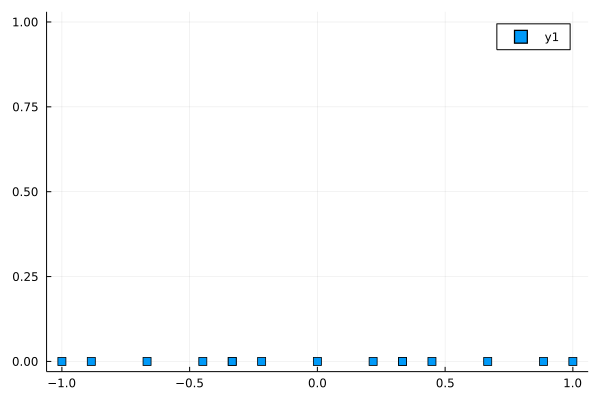

In [40]:
function xnodal(x, P)
    xn = Float64[]
    xref, _ = gausslobatto(P)
    for i in 1:nelem
        xL, xR = x[i:i+1]
        append!(xn, (xL+xR)/2 .+ (xR-xL)/2 * xref)
    end
    xn
end
xn = xnodal(x, 5)
scatter(xn, zero, marker=:square)

# Finite element building blocks

In [41]:
struct FESpace
    P::Int
    Q::Int
    nelem::Int
    x::Vector
    xn::Vector
    Et::Adjoint{Float64, SparseMatrixCSC{Float64, Int64}}
    q::Vector
    w::Vector
    B::Matrix
    D::Matrix
    function FESpace(P, Q, nelem)
        x, Et = fe1_mesh(P, nelem)
        xn = xnodal(x, P)
        _, q, w, B, D = febasis(P, Q)
        new(P, Q, nelem, x, xn, Et, q, w, B, D)
    end
end

In [42]:
function fe_element(fe, e)
    xL, xR = fe.x[e:e+1]
    q = (xL+xR)/2 .+ (xR-xL)/2*fe.q
    w = (xR - xL)/2 * fe.w
    E = fe.Et'[:, (e-1)*fe.P+1:e*fe.P]'
    dXdx = ones(fe.Q) * 2 / (xR - xL)
    q, w, E, dXdx
end

fe_element (generic function with 1 method)

# Finite element residual assembly
$$ v^T F(u) \sim \int_\Omega v\cdot f_0(u, \nabla u) + \nabla v\cdot f_1(u, \nabla u) = 0, \quad \forall v$$
$$ \sum_e \mathcal E_e^T \Big( B^T W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_0(\tilde u, \nabla \tilde u) + D^T \left(\frac{\partial X}{\partial x}\right)^{T} W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_1(\tilde u, \nabla\tilde u) \Big) = 0 $$
where $\tilde u = B \mathcal E_e u$ and $\nabla \tilde u = \frac{\partial X}{\partial x} D \mathcal E_e u$ are the values and gradients evaluated at quadrature points.

In [46]:
kappa(x) = 0.6 .+ 0.4*sin(pi*x/2)
fq(q, u, Du) = 0*u .- 1, kappa.(q) .* Du
dfq(q, u, du, Du, Ddu) = 0*du, kappa.(q) .* Ddu

function fe_residual(u_in, fe, fq; bci=[1], bcv=[1.])
    u = copy(u_in); v = zero(u)
    u[bci] = bcv
    for e in 1:fe.nelem
        q, w, E, dXdx = fe_element(fe, e)
        B, D = fe.B, fe.D
        ue = E * u
        uq = B * ue
        Duq = dXdx .* (D * ue)
        f0, f1 = fq(q, uq, Duq)
        ve = B' * (w .* f0) + D' * (dXdx .* w .* f1)
        v += E' * ve
    end
    v[bci] = u_in[bci] - u[bci]
    v
end

fe_residual (generic function with 1 method)

In [47]:
import NLsolve: nlsolve

fe = FESpace(3, 3, 5)
u0 = zero(fe.xn)
sol = nlsolve(u -> fe_residual(u, fe, fq), u0; method=:newton)
plot(fe.xn, sol.zero, marker=:auto)

LoadError: MethodError: [0mCannot `convert` an object of type [92mSparseMatrixCSC{Float64, Int64}[39m[0m to an object of type [91mAdjoint{Float64, SparseMatrixCSC{Float64, Int64}}[39m
[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::Factorization[39m) where T<:AbstractArray at /usr/share/julia/stdlib/v1.8/LinearAlgebra/src/factorization.jl:58
[0m  convert(::Type{Adjoint{T, S}}, [91m::Adjoint[39m) where {T, S} at /usr/share/julia/stdlib/v1.8/LinearAlgebra/src/adjtrans.jl:188
[0m  convert(::Type, [91m::GeoInterface.AbstractGeometryTrait[39m, [91m::Any[39m) at ~/.julia/packages/GeoInterface/J298z/src/fallbacks.jl:112
[0m  ...

# Finite element Jacobian assembly

$$ v^T F(u) \sim \int_\Omega v\cdot f_0(u, \nabla u) + \nabla v\cdot f_1(u, \nabla u) = 0, \quad \forall v$$
$$ v^T J(u) du \sim \int_\Omega v\cdot df_0(u, du, \nabla u, \nabla du) + \nabla v\cdot df_1(u, du, \nabla u, \nabla du) = 0, \quad \forall v$$

In [8]:
function fe_jacobian(u_in, fe, dfq; bci=[1], bcv=[1.])
    u = copy(u_in); u[bci] = bcv
    rows, cols, vals = Int[], Int[], Float64[]
    for e in 1:fe.nelem
        q, w, E, dXdx = fe_element(fe, e)
        B, D, P = fe.B, fe.D, fe.P
        ue = E * u
        uq = B * ue; Duq = dXdx .* (D * ue)
        K = zeros(P, P)
        for j in 1:fe.P
            du = B[:,j]
            Ddu = dXdx .* D[:,j]
            df0, df1 = dfq(q, uq, du, Duq, Ddu)
            K[:,j] = B' * (w .* df0) + D' * (dXdx .* w .* df1)
        end
        inds = rowvals(E')
        append!(rows, kron(ones(P), inds))
        append!(cols, kron(inds, ones(P)))
        append!(vals, vec(K))
    end
    A = sparse(rows, cols, vals)
    A[bci, :] .= 0; A[:, bci] .= 0
    A[bci,bci] = diagm(ones(length(bci)))
    A
end

fe_jacobian (generic function with 1 method)

In [9]:
sol = nlsolve(u -> fe_residual(u, fe, fq),
    u -> fe_jacobian(u, fe, dfq),
    u0;
    method=:newton)

LoadError: UndefVarError: nlsolve not defined

In [13]:
fe = FESpace(3, 3, 5)
u0 = zero(fe.xn)
function mass(q, u, du, Du, Ddu)
    df0 = du
    df1 = 0*du
    df0, df1
end
fe_jacobian(zero.(fe.xn), fe, mass, bci=[], bcv=[])

11×11 SparseMatrixCSC{Float64, Int64} with 41 stored entries:
  0.0533333  0.0266667  -0.0133333  …    ⋅          ⋅           ⋅ 
  0.0266667  0.213333    0.0266667       ⋅          ⋅           ⋅ 
 -0.0133333  0.0266667   0.106667        ⋅          ⋅           ⋅ 
   ⋅          ⋅          0.0266667       ⋅          ⋅           ⋅ 
   ⋅          ⋅         -0.0133333       ⋅          ⋅           ⋅ 
   ⋅          ⋅           ⋅         …    ⋅          ⋅           ⋅ 
   ⋅          ⋅           ⋅            -0.0133333   ⋅           ⋅ 
   ⋅          ⋅           ⋅             0.0266667   ⋅           ⋅ 
   ⋅          ⋅           ⋅             0.106667   0.0266667  -0.0133333
   ⋅          ⋅           ⋅             0.0266667  0.213333    0.0266667
   ⋅          ⋅           ⋅         …  -0.0133333  0.0266667   0.0533333

In [17]:
B = diagm(11, 10, 0 => ones(10))
B[end,:] = B[1,:]
B

11×10 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [19]:
sigma = 0.2
exp.(-fe.xn[1:end-1].^2/sigma^2)

10-element Vector{Float64}:
 1.388794386496407e-11
 1.1253517471925912e-7
 0.00012340980408667956
 0.01831563888873418
 0.36787944117144256
 1.0
 0.36787944117144256
 0.01831563888873418
 0.00012340980408667956
 1.1253517471925912e-7

In [23]:
exp(A)

LoadError: UndefVarError: A not defined

In [21]:
using LinearAlgebra

# Spy on the Jacobian

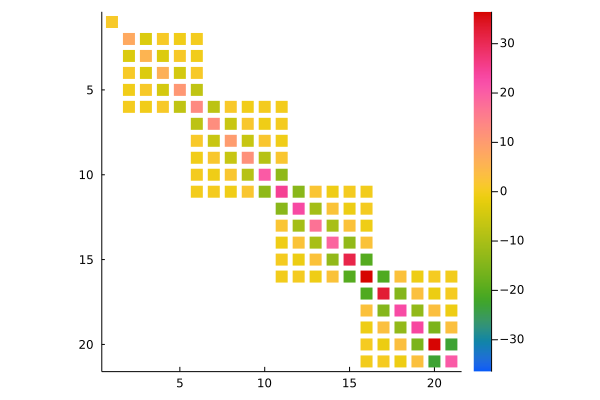

In [140]:
#@show cond(Matrix(J))

fe = FESpace(6, 6, 4)
u0 = zero(fe.xn)
J = fe_jacobian(u0, fe, dfq)
my_spy(J)

* What is interesting about this matrix structure?
  * What would the matrix structure look like for a finite difference method that is 6th order accurate?